In [1]:
# imports
import numpy as np
import psutil
import torch

from collections import deque
from unityagents import UnityEnvironment

from agent_p2 import Agent

import matplotlib.pyplot as plt

In [2]:
# start environment
env = UnityEnvironment(
        file_name='Reacher_Windows_x86_64/Reacher.exe',
        no_graphics=True
    )

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


In [4]:
def cleanup_zombie_processes():
    for proc in psutil.process_iter(['pid', 'ppid', 'name', 'status']):
        if proc.info['name'] == 'Reacher_One_Lin' and proc.info['status'] == 'zombie':
            print(f"Zombie process detected: {proc.info}")
            parent = psutil.Process(proc.info['ppid'])
            print(f"Terminating parent process: {parent}")
            parent.terminate()

In [5]:
def ddpg(agent, env, n_episodes=500, goal=30.0, train_mode=True, episode_window=100, print_every=10):
    """ Deep Deterministic Policy  Gradient
        Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    scores_window = deque(maxlen=episode_window)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    brain_name = env.brain_names[0]
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(len(env_info.agents))                # initialize the score (for each agent)
        agent.reset()
        step_num = 0
    
        while True:
            actions = agent.act(states, noise=True)             # select an action
            # env_info = env.step(actions)[brain_name]            # send the action to the environment
            env_info = env.step({brain_name: actions.detach().cpu().numpy()})[brain_name]
            next_states = env_info.vector_observations          # get the next state
            rewards = env_info.rewards                          # get the reward
            dones = env_info.local_done  
    
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, step_num)
    
            states = next_states
            scores += rewards
            step_num += 1
    
            if np.any(dones):                                  # exit loop if episode finished
                break
    
        min_scores.append(np.min(scores))             # save lowest score for a single agent
        max_scores.append(np.max(scores))             # save highest score for a single agent        
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, moving_avgs[i_episode-1]))
        if train_mode and i_episode % print_every == 0:
            torch.save(agent.actor.state_dict(), 'weights\\actor\checkpoint_'+str(i_episode)+'.pth')
            torch.save(agent.critic.state_dict(), 'weights\critic\checkpoint_'+str(i_episode)+'.pth')
                  
        if moving_avgs[-1] >= goal and i_episode >= episode_window:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode-episode_window, moving_avgs[-1], episode_window))            
            if train_mode:
                torch.save(agent.actor.state_dict(), 'weights\\actor\\trained_weights.pth')
                torch.save(agent.critic.state_dict(), 'weights\critic\\trained_weights.pth')  
            break
    goal_vec = np.ones(i_episode)*goal
    return mean_scores, moving_avgs, goal_vec

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

In [7]:
# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

In [8]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

d:\Anaconda\Programa\envs\drlnd\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1	Average Score: 0.36
Episode 2	Average Score: 0.93
Episode 3	Average Score: 1.56
Episode 4	Average Score: 2.42
Episode 5	Average Score: 3.54
Episode 6	Average Score: 5.14
Episode 7	Average Score: 6.76
Episode 8	Average Score: 8.02
Episode 9	Average Score: 9.34
Episode 10	Average Score: 10.98
Episode 11	Average Score: 12.37
Episode 12	Average Score: 13.37
Episode 13	Average Score: 14.30
Episode 14	Average Score: 15.16
Episode 15	Average Score: 15.78
Episode 16	Average Score: 16.45
Episode 17	Average Score: 17.07
Episode 18	Average Score: 17.63
Episode 19	Average Score: 18.10
Episode 20	Average Score: 18.61
Episode 21	Average Score: 19.13
Episode 22	Average Score: 19.64
Episode 23	Average Score: 20.05
Episode 24	Average Score: 20.43
Episode 25	Average Score: 20.62
Episode 26	Average Score: 20.89
Episode 27	Average Score: 21.24
Episode 28	Average Score: 21.56
Episode 29	Average Score: 21.83
Episode 30	Average Score: 22.09
Episode 31	Average Score: 22.32
Episode 32	Average Score: 

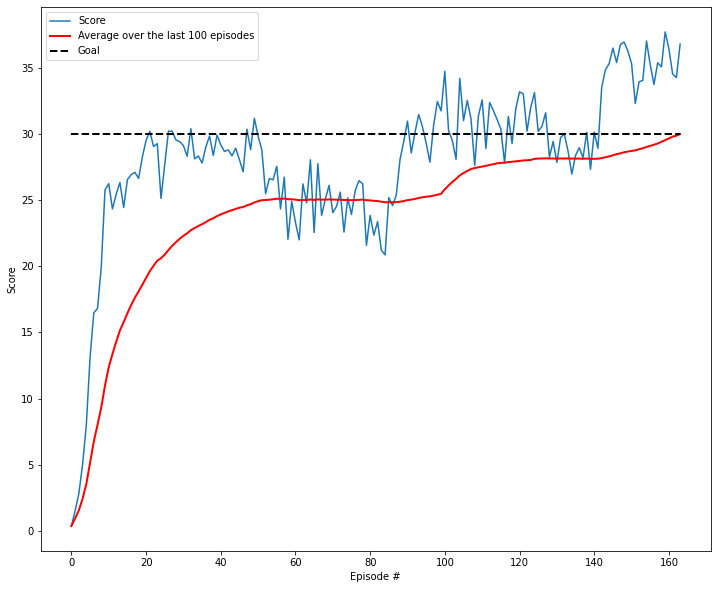

In [10]:
mean_scores, moving_avgs, goal_vec= ddpg(agent, env, n_episodes=500, goal=30.0, train_mode=True, episode_window=100, print_every=20)

env.close()

# Check for zombie processes
cleanup_zombie_processes()

# plot the scores
fig = plt.figure(figsize=(12, 10))
plt.plot(np.arange(len(mean_scores)), mean_scores, label = 'Score')
plt.plot(moving_avgs, 'r-', label = 'Average over the last 100 episodes',linewidth = 2)
plt.plot(goal_vec, 'k--',label = 'Goal', linewidth = 2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()